In [10]:
import bioframe as bf
from gpn.data import load_table
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
cols = ["chrom", "pos", "ref", "alt"]
dataset_path = "results/eqtl/matched/ge"

In [3]:
models = [
    #"CADD.RawScore",
    #"phyloP",
    #"phastCons",
    #"phyloP-Zoonomia",
    #"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species.LogisticRegression",
    "Enformer.LogisticRegression",
    "LongSafari/hyenadna-large-1m-seqlen-hf.LogisticRegression",
    
    "multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression",
    "multiz100way/89/512/256/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression",
]

model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",
    "phyloP": "phyloP-100-vertebrates",
    "phastCons": "phastCons-100-vertebrates",
    "phyloP-Zoonomia": "phyloP-241-mammals",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species": "NT",
    "LongSafari/hyenadna-large-1m-seqlen-hf": "HyenaDNA",
    "multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA-256",
}

V = pd.read_parquet(f"../../{dataset_path}/test.parquet")
d = Path(f"../../results/preds/{dataset_path}")
for m in models:
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V

,chrom,pos,ref,alt,pip,maf,label,match_group,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,InstaDeepAI/nucleotide-transformer-2.5b-multi-species.LogisticRegression,Enformer.LogisticRegression,LongSafari/hyenadna-large-1m-seqlen-hf.LogisticRegression,multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,multiz100way/89/512/256/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression
0,1,14677,G,A,0.992227,0.055024,True,0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,54490,G,A,1.000000,0.159938,True,1,-0.368067,-0.318062,-0.369354,-0.719619,-0.277018,-0.286408
2,1,63671,G,A,0.998592,0.156388,True,2,-0.398127,-0.131802,-0.492625,-0.715623,-0.404368,-0.463321
3,1,63697,T,C,0.977568,0.195652,True,3,NaN,NaN,NaN,NaN,NaN,NaN
4,1,108826,G,C,1.000000,0.040023,True,4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21571,X,155203528,C,T,0.009518,0.279275,False,10692,NaN,NaN,NaN,NaN,NaN,NaN
21572,X,155559972,A,T,0.008540,0.279240,False,10678,NaN,NaN,NaN,NaN,NaN,NaN
21573,X,155672303,G,A,0.962191,0.436727,True,10785,NaN,NaN,NaN,NaN,NaN,NaN
21574,X,155768650,G,T,0.991784,0.455970,True,10786,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
annotation = load_table("../../results/annotation.gtf.gz")
annotation

,chrom,source,feature,start,end,score,strand,frame,attribute
0,1,ensembl_havana,gene,1471764,1497848,.,+,.,"gene_id ""ENSG00000160072""; gene_version ""20""; ..."
1,1,ensembl_havana,transcript,1471764,1497848,.,+,.,"gene_id ""ENSG00000160072""; gene_version ""20""; ..."
2,1,ensembl_havana,exon,1471764,1472089,.,+,.,"gene_id ""ENSG00000160072""; gene_version ""20""; ..."
3,1,ensembl_havana,CDS,1471884,1472089,.,+,0,"gene_id ""ENSG00000160072""; gene_version ""20""; ..."
4,1,ensembl_havana,start_codon,1471884,1471887,.,+,0,"gene_id ""ENSG00000160072""; gene_version ""20""; ..."
...,...,...,...,...,...,...,...,...,...
3370663,MT,insdc,transcript,15887,15953,.,+,.,"gene_id ""ENSG00000210195""; gene_version ""2""; t..."
3370664,MT,insdc,exon,15887,15953,.,+,.,"gene_id ""ENSG00000210195""; gene_version ""2""; t..."
3370665,MT,insdc,gene,15955,16023,.,-,.,"gene_id ""ENSG00000210196""; gene_version ""2""; g..."
3370666,MT,insdc,transcript,15955,16023,.,-,.,"gene_id ""ENSG00000210196""; gene_version ""2""; t..."


In [7]:
tx = annotation.query('feature=="transcript"').copy()
tx["gene_id"] = tx.attribute.str.extract(r'gene_id "([^;]*)";')
tx["transcript_biotype"] = tx.attribute.str.extract(r'transcript_biotype "([^;]*)";')
tx = tx[tx.transcript_biotype=="protein_coding"]
tx

,chrom,source,feature,start,end,score,strand,frame,attribute,gene_id,transcript_biotype
1,1,ensembl_havana,transcript,1471764,1497848,.,+,.,"gene_id ""ENSG00000160072""; gene_version ""20""; ...",ENSG00000160072,protein_coding
75,1,ensembl,transcript,1471783,1496201,.,+,.,"gene_id ""ENSG00000160072""; gene_version ""20""; ...",ENSG00000160072,protein_coding
133,1,havana,transcript,3069167,3434342,.,+,.,"gene_id ""ENSG00000142611""; gene_version ""17""; ...",ENSG00000142611,protein_coding
173,1,havana,transcript,3069196,3435421,.,+,.,"gene_id ""ENSG00000142611""; gene_version ""17""; ...",ENSG00000142611,protein_coding
212,1,havana,transcript,3069210,3434342,.,+,.,"gene_id ""ENSG00000142611""; gene_version ""17""; ...",ENSG00000142611,protein_coding
...,...,...,...,...,...,...,...,...,...,...,...
3370623,MT,insdc,transcript,10469,10766,.,+,.,"gene_id ""ENSG00000212907""; gene_version ""2""; t...",ENSG00000212907,protein_coding
3370629,MT,insdc,transcript,10759,12137,.,+,.,"gene_id ""ENSG00000198886""; gene_version ""2""; t...",ENSG00000198886,protein_coding
3370643,MT,insdc,transcript,12336,14148,.,+,.,"gene_id ""ENSG00000198786""; gene_version ""2""; t...",ENSG00000198786,protein_coding
3370649,MT,insdc,transcript,14148,14673,.,-,.,"gene_id ""ENSG00000198695""; gene_version ""2""; t...",ENSG00000198695,protein_coding


In [8]:
tss = tx.copy()
tss[["start", "end"]] = tss.progress_apply(lambda w: (w.start, w.start+1) if w.strand=="+" else (w.end-1, w.end), axis=1, result_type="expand")
tss = tss[["chrom", "start", "end", "gene_id"]]
tss

100%|██████████| 88714/88714 [00:02<00:00, 31475.41it/s]


,chrom,start,end,gene_id
1,1,1471764,1471765,ENSG00000160072
75,1,1471783,1471784,ENSG00000160072
133,1,3069167,3069168,ENSG00000142611
173,1,3069196,3069197,ENSG00000142611
212,1,3069210,3069211,ENSG00000142611
...,...,...,...,...
3370623,MT,10469,10470,ENSG00000212907
3370629,MT,10759,10760,ENSG00000198886
3370643,MT,12336,12337,ENSG00000198786
3370649,MT,14672,14673,ENSG00000198695


In [9]:
V = bf.closest(V, tss).rename(columns={"gene_id_": "gene_id"})
V

NameError: name 'bf' is not defined

In [4]:
"""
exclude_abs = ["CADD", "phyloP", "phyloP-100-vertebrates", "phyloP-241-mammals", "phyloP-Zoonomia", 'phastCons-100-vertebrates']
for m in models:
    if m in V.columns and m not in exclude_abs:
        print(m)
        V[m] = -V[m].abs()
""";

In [5]:
V.dropna(
    subset=models,
    inplace=True
)
V

,chrom,pos,ref,alt,pip,maf,label,match_group,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,InstaDeepAI/nucleotide-transformer-2.5b-multi-species.LogisticRegression,Enformer.LogisticRegression,LongSafari/hyenadna-large-1m-seqlen-hf.LogisticRegression,multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,multiz100way/89/512/256/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression
1,1,54490,G,A,1.000000,0.159938,True,1,-0.368067,-0.318062,-0.369354,-0.719619,-0.277018,-0.286408
2,1,63671,G,A,0.998592,0.156388,True,2,-0.398127,-0.131802,-0.492625,-0.715623,-0.404368,-0.463321
5,1,286747,A,G,1.000000,0.151295,True,5,-0.250317,-0.192020,-0.330500,-0.713370,-0.200899,-0.250862
7,1,912710,G,A,0.008546,0.222110,False,482,-0.658128,-0.828943,-0.532547,-0.684749,-0.707262,-0.712579
8,1,917584,T,G,0.996919,0.199664,True,7,-0.830657,-0.746918,-0.877497,-0.699925,-0.624127,-0.803591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21047,22,50665387,T,A,0.006481,0.030702,False,10404,-0.312640,-0.479534,-0.382277,-0.907316,-0.497780,-0.410617
21048,22,50665389,G,A,0.006481,0.030702,False,10418,-0.300950,-0.420923,-0.441479,-0.907319,-0.492368,-0.404316
21049,22,50733265,G,A,0.971032,0.302632,True,10523,-0.716176,-0.848931,-0.430740,-0.849880,-0.764370,-0.664425
21050,22,50783672,G,T,0.964513,0.080189,True,10524,-0.952083,-0.818909,-1.000000,-0.798859,-0.966836,-0.937609


In [6]:
V = V[V.duplicated("match_group", keep=False)]
V.label.value_counts()

label
True     9544
False    9544
Name: count, dtype: int64

## Testing

In [7]:
def get_subtitle(n_pathogenic, n_benign):
    return f"n={n_pathogenic} vs. {n_benign}"

pos_prop = []

rows = []
V_c = V
n_pos, n_neg = (V_c.label==True).sum(), (V_c.label==False).sum()
subtitle = get_subtitle(n_pos, n_neg)
pos_prop.append(n_pos/(n_pos+n_neg))

for m in tqdm(models):
    AUROC = roc_auc_score(V_c.label==True, -V_c[m])
    rows.append([m, AUROC])
results = pd.DataFrame(rows, columns=["Model", "AUROC"]).sort_values("AUROC", ascending=False)
results

100%|██████████| 6/6 [00:00<00:00, 112.69it/s]


,Model,AUROC
2,Enformer.LogisticRegression,0.780266
1,InstaDeepAI/nucleotide-transformer-2.5b-multi-...,0.760129
5,multiz100way/89/512/256/True/defined.phastCons...,0.746459
4,multiz100way/89/256/128/True/defined.phastCons...,0.740604
0,multiz100way/89/128/64/True/defined.phastCons....,0.732733
3,LongSafari/hyenadna-large-1m-seqlen-hf.Logisti...,0.703985


In [8]:
#results.to_parquet("results_eqtl.parquet", index=False)

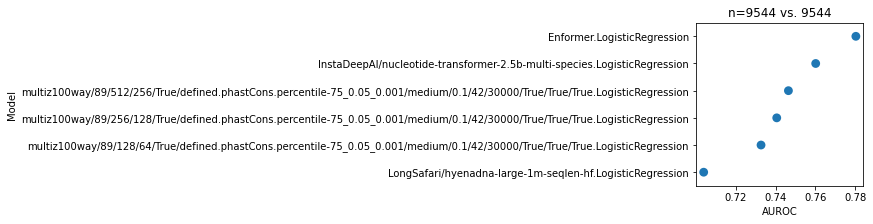

In [9]:
plt.figure(figsize=(3,3))
sns.pointplot(
    data=results.replace({
        "Enformer_l2": "Enformer",
        "GPN-MSA": "GPN-MSA (LLR)",
    }),
    y="Model",
    x="AUROC",
    join=False,
)
plt.title(subtitle);